In [1]:
%run import_libs.py

### get data

In [2]:
short_list = [
    'P_2_last', 'B_1_last', 'B_3_last', 'D_39_last', 'D_41_last', 'D_45_max', 'B_28_min', 'D_42_avg', 'B_14_last',
    'D_50_last','B_5_last','B_4_last','D_44_last','P_2_min','D_46_last','D_51_avg','B_2_avg','P_2_avg','D_49_last',
    'S_3_last','S_3_avg','D_43_avg','B_4_max', 'D_39_max', 'D_43_last', 'S_5_last', 'B_7_last', 'B_18_last', 'P_3_avg', 
    'B_9_last', 'R_4_last', 'R_2_last', 'D_121_min', 'S_26_max'
]

In [3]:
df_train = get_train_data(TRAIN_PATH='./data/train.parquet')
num_features = pd.read_csv("num_feats_after_filtering.csv")["0"].to_list()
# num_features = short_list

df_train_agg = get_df_w_aggrs(df=df_train, feats=num_features)
df_train_target = get_target(TARGET_PATH='./data/train_labels.csv')
df_train = get_train_data_with_target_merged(df_train=df_train_agg, df_train_target=df_train_target)

(458913, 151)
(458913, 151)
(458913, 151)
(458913, 162)
(458913, 616)


In [4]:
df_test = get_test_data(TEST_PATH='./data/test.parquet')
df_test = get_df_w_aggrs(df=df_test, feats=num_features)

(924621, 151)
(924621, 151)
(924621, 151)
(924621, 162)
(924621, 616)


In [5]:
# оставляем только short_list
df_train = df_train[['customer_ID'] + short_list + ['target']]
df_test = df_test[['customer_ID'] + short_list]

### fit model

In [17]:
len(short_list)

34

In [16]:
# fit predict engeneering
random_state = 42
group_col = 'customer_ID'
target_col = 'target'
y, groups = df_train[target_col].values, df_train[group_col].values
fold_scores, fold_test_raw = [], []

sgkf = StratifiedGroupKFold(5, shuffle=True, random_state=random_state)

params = dict(
    learning_rate=.05, subsample=.9, subsample_freq=1,
    colsample_bytree=.8, objective='binary',
    random_state=random_state,
    max_depth=7, n_estimators=484,
    n_jobs=-1, verbosity=-1
)

for fold, (tr_idx, va_idx) in enumerate(
        sgkf.split(df_train[[group_col, target_col]], y, groups)):
    print(f"Fold {fold}")
    X_tr, X_va = df_train.iloc[tr_idx][short_list], df_train.iloc[va_idx][short_list]
    y_tr, y_va = y[tr_idx], y[va_idx]
    model = LGBMClassifier(**params)
    model.fit(X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric=lgb_amex_metric)
    pred_va = model.predict_proba(X_va)[:,1]
    sc = get_amex_metric_calculated(y_va, pred_va)
    print(f" Amex = {sc:.5f}")
    fold_scores.append(sc)
    fold_test_raw.append(model.predict_proba(df_test[short_list], raw_score=True))

Fold 0
 Amex = 0.77913
Fold 1
 Amex = 0.78145
Fold 2
 Amex = 0.78321
Fold 3
 Amex = 0.77928
Fold 4
 Amex = 0.78402


In [18]:
mean_cv = float(np.mean(fold_scores))
print(f"Mean CV Amex = {mean_cv:.5f}")

Mean CV Amex = 0.78142


In [ ]:
model_full = LGBMClassifier(**params).fit(
    df_train[short_list], df_train[target_col])

gains = model_full.booster_.feature_importance('gain')
imp_df = (pd.DataFrame({'feature': short_list, 'gain': gains})
            .sort_values('gain', ascending=False))
imp_df['share'] = imp_df['gain'] / imp_df['gain'].sum()

In [22]:
with open("list_perm_imp_dfs.pkl", "rb") as f:
    perm_imp_df = pickle.load(f)

In [33]:
df_imp_merged = (imp_df
.merge(perm_imp_df[40]['importance'], on='feature')
)

df_imp_merged.columns = ["feature", "imp_gain", 'share_gain', 'imp_perm']
df_imp_merged['share_perm'] = df_imp_merged['imp_perm'] / df_imp_merged['imp_perm'].sum()

In [ ]:
df_imp_merged.head(3)

feature      imp_gain  share_gain  imp_perm  share_perm
0  P_2_last  1.392982e+06    0.451848  0.053632    0.250459
1   P_2_avg  3.099985e+05    0.100556  0.004279    0.019985
2   P_2_min  2.498633e+05    0.081049  0.004871    0.022745

In [37]:
# save importance df final model
df_imp_merged.to_csv("gain_and_permutation_feature_importance_short_list.csv", index=None)

### hyperparameter search (optuna)

In [6]:
def run_final_optuna_tuning(X, y, groups, cat_feats=None, random_state=42, n_trials=50):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

    def objective(trial):
        params = {
            'learning_rate': 0.05,
            'max_depth': trial.suggest_int("max_depth", 3, 10),
            'n_estimators': trial.suggest_int("n_estimators", 200, 800),
            'subsample': trial.suggest_float("subsample", 0.6, 1.0),
            'subsample_freq': 1,
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
            'reg_alpha': trial.suggest_float("reg_alpha", 0.0, 10.0),
            'reg_lambda': trial.suggest_float("reg_lambda", 0.0, 10.0),
            'random_state': random_state,
            'objective': 'binary',
            'n_jobs': -1,
            'verbosity': -1
        }

        fold_scores = []
        for tr_idx, va_idx in sgkf.split(X, y, groups):
            model = LGBMClassifier(**params)
            model.fit(X.iloc[tr_idx], y[tr_idx],
                      categorical_feature=cat_feats)
            pred = model.predict_proba(X.iloc[va_idx])[:, 1]
            score = get_amex_metric_calculated(y[va_idx], pred)
            fold_scores.append(score)

        return -np.mean(fold_scores)  # minimize negative amex

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, n_jobs=-1, show_progress_bar=True)

    print("Best score:", -study.best_value)
    print("Best params:", study.best_params)

    return study.best_params, study


In [9]:
random_state = 42
group_col = 'customer_ID'
target_col = 'target'
y_train, groups = df_train[target_col].values, df_train[group_col].values
fold_scores, fold_test_raw = [], []


best_params, study = run_final_optuna_tuning(
    df_train[short_list], y_train, groups, cat_feats=None, n_trials=50
)

[I 2025-05-15 16:11:20,119] A new study created in memory with name: no-name-8308f062-a7bb-4498-85d7-19c8fdf9a0b1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-15 16:27:29,039] Trial 5 finished with value: -0.7777788070164047 and parameters: {'max_depth': 5, 'n_estimators': 223, 'subsample': 0.8482270674359601, 'colsample_bytree': 0.7406285675919403, 'reg_alpha': 1.805093591482675, 'reg_lambda': 0.9262532698743453}. Best is trial 5 with value: -0.7777788070164047.
[I 2025-05-15 16:28:24,439] Trial 0 finished with value: -0.7800446206785838 and parameters: {'max_depth': 7, 'n_estimators': 221, 'subsample': 0.7595408270962891, 'colsample_bytree': 0.9336390760778533, 'reg_alpha': 7.123240857451581, 'reg_lambda': 0.9850634279267501}. Best is trial 0 with value: -0.7800446206785838.
[I 2025-05-15 16:31:46,477] Trial 7 finished with value: -0.781315275634358 and parameters: {'max_depth': 10, 'n_estimators': 274, 'subsample': 0.6967860291096907, 'colsample_bytree': 0.7753019688077294, 'reg_alpha': 0.8028714336215914, 'reg_lambda': 0.3855236636318182}. Best is trial 7 with value: -0.781315275634358.
[I 2025-05-15 16:31:49,453] Trial 4 fini

### save final model

In [8]:
y_pred_list = []
params = {
    'learning_rate': 0.05,
    'max_depth': 7,
    'n_estimators': 755,
    'subsample': 0.7245817917193483,
    'subsample_freq': 1,
    'colsample_bytree': 0.769468392260658,
    'reg_alpha': 8.580667877736142,
    'reg_lambda': 6.373340815995653,
    'random_state': 42,
    'objective': 'binary',
    'n_jobs': -1,
    'verbosity': -1
}

model_full = LGBMClassifier(**params).fit(
    df_train[short_list], df_train['target'])

y_pred_list.append(model_full.predict_proba(df_test[short_list], raw_score=True))

In [15]:
INFERENCE = True

if INFERENCE:
    sub = pd.DataFrame({'customer_ID': df_test.customer_ID,
                        'prediction': y_pred_list[0]})
    sub.to_csv('submission_final_model_lgb_short_list.csv', index=False)
    display(sub)

customer_ID  prediction
0       00000469ba478561f23a92a868bd366de6f6527a684c9a...   -3.512088
1       00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...   -6.782039
2       0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...   -2.529866
3       00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...   -0.702095
4       00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...    1.897224
...                                                   ...         ...
924616  ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...   -3.761623
924617  ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...    0.783327
924618  ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...    0.298736
924619  ffffddef1fc3643ea179c93245b68dca0f36941cd83977...   -0.307980
924620  fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...   -2.305504

[924621 rows x 2 columns]

In [16]:
import pickle

# Save model
with open("model_full.pkl", "wb") as f:
    pickle.dump(model_full, f)

### SHAP

In [38]:
model_full

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               n_estimators=484, n_jobs=-1, objective='binary', random_state=42,
               subsample=0.9, subsample_freq=1, verbosity=-1)

In [42]:
df_train[short_list].shape

(458913, 34)

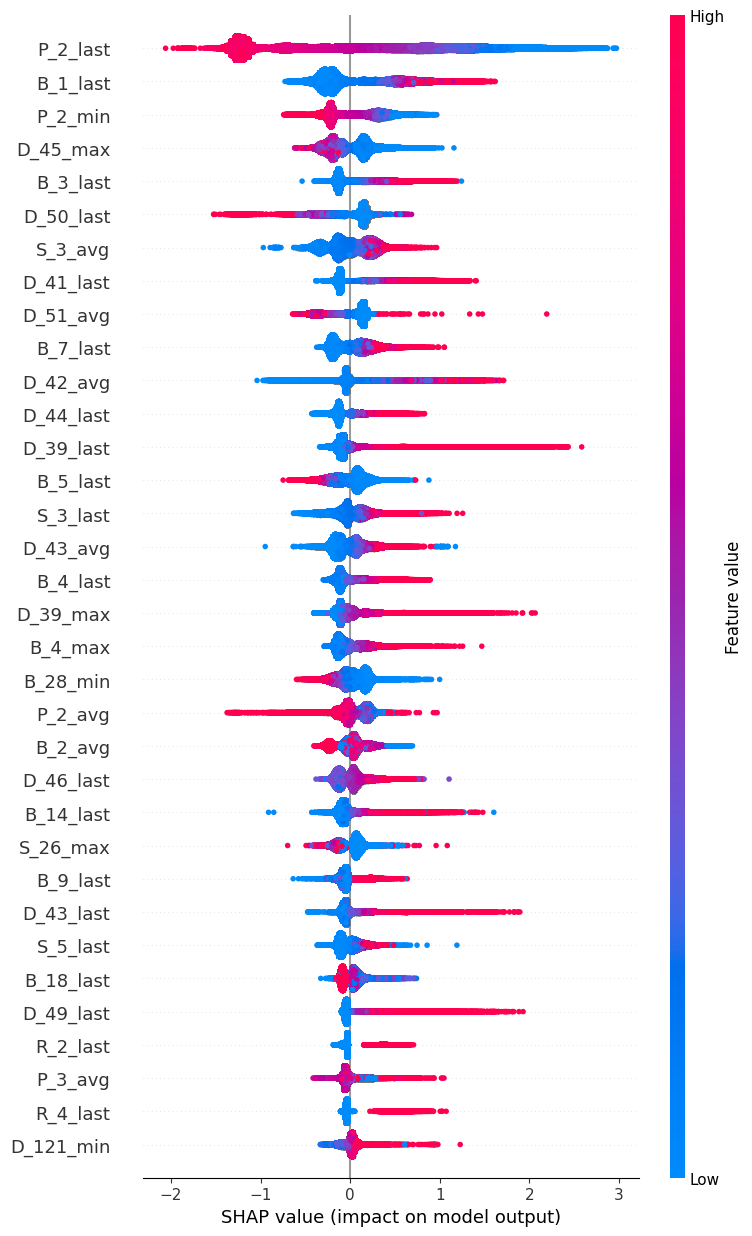

In [ ]:
# shap на train-е
explainer = shap.Explainer(model_full)
explanation = explainer(df_train[short_list])
shap.plots.beeswarm(explanation, max_display=None)

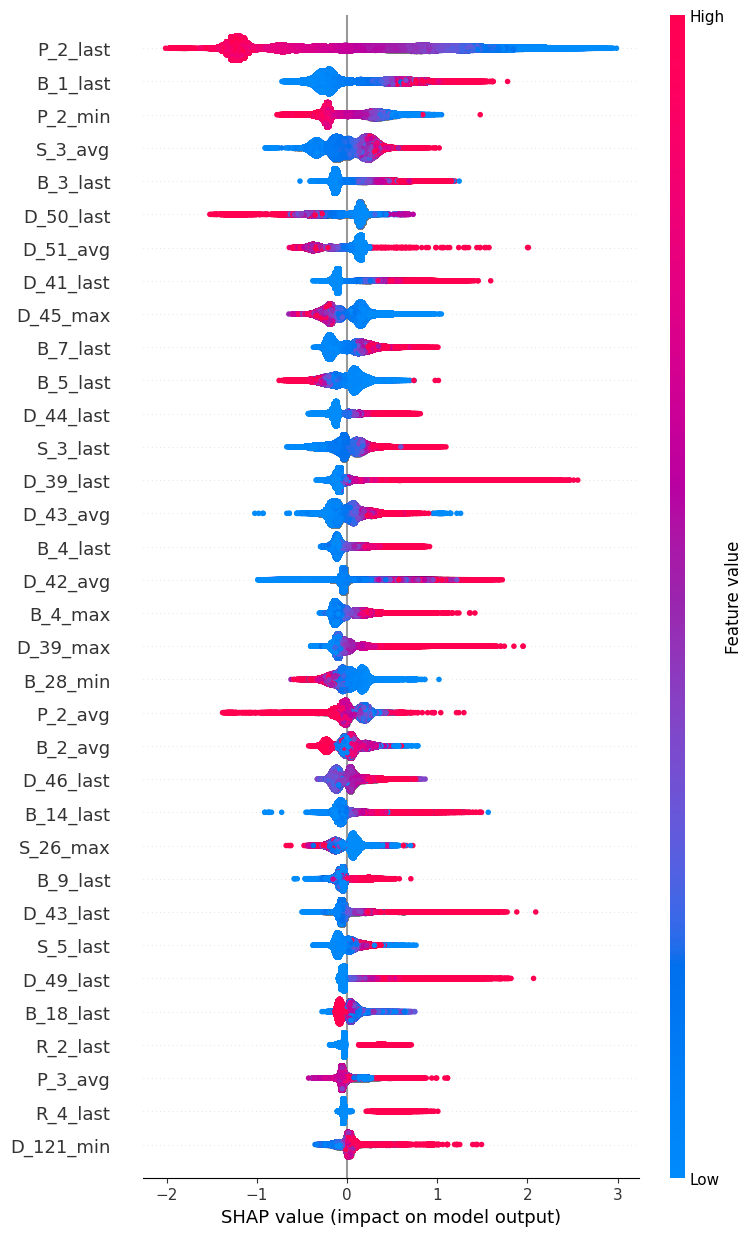

In [48]:
# shap на тесте
explainer = shap.Explainer(model_full)
explanation = explainer(df_test[short_list])
shap.plots.beeswarm(explanation, max_display=None)

### LIME

In [6]:
f = open("model_full.pkl",'rb')
model_full = pickle.load(f)
# model_full

In [7]:
df_test[short_list].head(3)

P_2_last  B_1_last  B_3_last  D_39_last  D_41_last  D_45_max  B_28_min  \
0  0.568930  0.010779  0.003576          4        0.0  0.025111  0.133804   
1  0.841177  0.016562  0.011386          4        0.0  0.099732  0.008613   
2  0.697522  0.001484  0.015938          0        0.0  0.068810  0.029066   

   D_42_avg  B_14_last  D_50_last  ...  D_43_last  S_5_last  B_7_last  \
0  0.118016   0.008621        NaN  ...   0.007398  0.011795  0.163441   
1       NaN   0.010847        NaN  ...        NaN  0.009336  0.014466   
2       NaN   0.004427        NaN  ...   0.105303  0.004455  0.090228   

   B_18_last   P_3_avg  B_9_last  R_4_last  R_2_last  D_121_min  S_26_max  
0   0.590569  0.591933  0.005263         0         0   0.192405  0.083706  
1   1.000000  0.553269  0.017454         0         0   0.827385  0.022272  
2   0.585974  0.670820  0.008629         0         0   0.262928  0.012020  

[3 rows x 34 columns]

In [7]:
explainer = lime.lime_tabular.LimeTabularExplainer(df_train[short_list].values, mode='classification', feature_names=short_list, class_names=[0, 1], discretize_continuous=True)

In [ ]:
# 50/50 case
i = 50
exp = explainer.explain_instance(df_train[short_list].iloc[i], model_full.predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

print("Ground truth:", df_train['target'].iloc[i])

c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

Ground truth: 0


In [ ]:
# 70 (0) / 30 (1) case
i = 40
exp = explainer.explain_instance(df_train[short_list].iloc[i], model_full.predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

print("Ground truth:", df_train['target'].iloc[i])

c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

Ground truth: 0


In [16]:
# 5% (0) / 95% (1) case
i = 76
exp = explainer.explain_instance(df_train[short_list].iloc[i], model_full.predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

print("Ground truth:", df_train['target'].iloc[i])

c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

Ground truth: 1


In [67]:
df_train[df_train.notna().all(axis=1)]

customer_ID  P_2_last  B_1_last  \
11      00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4... -0.015913  0.100166   
21      00039533fe0b61bcf1ec0d1aefe6acb5469ea0f0d1b0ad...  0.234922  0.607450   
40      00062483fb33d6129dd4ee7e5a12f751d2e7010ac0df01...  0.573481  0.021270   
50      000772ede38fe3811dea0dff9dc50e2f8b7b577ab6f143...  0.276098  0.015358   
76      000bbcea7cf6a9d74b2ff2f6fd4fa89a4ff4c419a8b569...  0.245102  0.058433   
...                                                   ...       ...       ...   
458785  ffeea01a48ebd3fec19fe0bbb8f88b79d8d49069d86c6b...  0.570546  0.026308   
458864  fff908439f19e2b2a4eb26432d51d8e38a0b757515f0f3...  0.644561  0.027423   
458874  fffac44d9cf2cce85f5ac7a228d6a7c0b875f074c89a6c...  0.581932  0.001153   
458905  fffee847c5c1af7dbdd36d98fea882893256c422cde86c...  0.786780  0.003976   
458907  ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...  0.794828  0.069242   

        B_3_last  D_39_last  D_41_last  D_45_max  B_28_min  D_42_avg  \
11      0.192567          1   0.256431  0.044835  0.155219  0.280145   
21      0.716291          3   0.000000  0.057646  0.138483  0.098498   
40      0.003341          0   0.000000  0.022588  0.144913  0.029290   
50      0.028025          0   0.000000  0.022584  0.008954  0.152257   
76      0.138842          0   0.367337  0.031245  0.010914  0.221807   
...          ...        ...        ...       ...       ...       ...   
458785  0.098568          0   0.000000  0.027638  0.007658  0.278042   
458864  0.004047          0   0.000000  0.024282  0.020069  0.103779   
458874  0.008040          0   0.000000  0.017852  0.055626  0.288212   
458905  0.008056          0   0.000000  0.049052  0.053012  0.004265   
458907  0.289190          1   0.000000  0.038724  0.018848  0.006290   

        B_14_last  ...  S_5_last  B_7_last  B_18_last   P_3_avg  B_9_last  \
11       0.026419  ...  0.071783  0.664943   0.121258  0.422899  0.546156   
21       0.143586  ...  0.042791  0.761991   0.203300  0.504931  0.650132   
40       0.003882  ...  0.002278  0.252951   0.533654  0.481362  0.039318   
50       0.008820  ...  0.010525  0.108832   0.648504  0.593974  0.066319   
76       0.023997  ...  0.108221  0.365136   0.118806  0.510676  0.612881   
...           ...  ...       ...       ...        ...       ...       ...   
458785   0.009549  ...  0.008575  0.151594   0.652352  0.605908  0.020677   
458864   0.157156  ...  0.133547  0.028255   1.000000  0.870649  0.002955   
458874   0.009942  ...  0.005270  0.216414   0.531814  0.384794  0.008223   
458905   0.002303  ...  0.005579  0.120542   0.528101  0.745010  0.004839   
458907   0.017500  ...  0.002880  0.037397   0.507673  0.663327  0.038457   

        R_4_last  R_2_last  D_121_min  S_26_max  target  
11             1         1   0.652967  0.009174       1  
21             0         0   0.592678  0.008857       1  
40             0         0   0.759668  0.009039       0  
50             0         0   0.396326  0.032275       0  
76             0         0   0.009066  0.009716       1  
...          ...       ...        ...       ...     ...  
458785         0         0   0.407045  0.009403       1  
458864         0         0   0.548295  0.301117       0  
458874         0         0   0.396789  0.009928       1  
458905         0         0   0.373914  0.186575       0  
458907         0         0   0.548125  0.278492       0  

[18723 rows x 36 columns]

### DALEX

In [17]:
import dalex as dx

In [19]:
exp = dx.Explainer(model_full, df_train[short_list], df_train['target'], label="LightGBM model")

Preparation of a new explainer is initiated

  -> data              : 458913 rows 34 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 458913 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : LightGBM model
  -> predict function  : <function yhat_proba_default at 0x0000025D29B487C0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000127, mean = 0.259, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.996, mean = 3.78e-05, max = 0.999
  -> model_info        : package lightgbm

A new explainer has been created!


In [23]:
vi = exp.model_parts()
vi.plot(max_vars=35)

In [24]:
pdp = exp.model_profile()
pdp.plot()

Calculating ceteris paribus:   9%|▉         | 3/34 [00:00<00:06,  4.94it/s]c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\dalex\predict_explanations\_ceteris_paribus\utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0.    1.7   3.4 ... 166.6 168.3 170. ]' has dtype incompatible with int16, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:  32%|███▏      | 11/34 [00:02<00:04,  5.61it/s]c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\dalex\predict_explanations\_ceteris_paribus\utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0.     3.45   6.9  ... 338.1  341.55 345.  ]' has dtype incompatible with int16, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:  35%|███▌      | 12/34 [00:02<00:04,  5.33it/s]c:\Users\oobu

In [26]:
pdp = exp.model_profile(variables=["P_2_last"])
pdp.plot()

Calculating ceteris paribus:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


In [ ]:
pdp = exp.model_profile(variables=["D_45_max"])
pdp.plot()

In [ ]:
obs = X_sample.iloc[0]

In [27]:
i = 50
obs = df_train[short_list].iloc[i]

In [ ]:
le = exp.predict_parts(obs)
le.plot()

c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\dalex\predict_explanations\_break_down\utils.py:124: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\dalex\predict_explanations\_break_down\utils.py:124: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\oobur\Projects\spbu_master\sem4\vkr\.venv\Lib\site-packages\dalex\predict_explanations\_break_down\utils.py:124: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

In [ ]:
exp.model_performance().plot()